# Analysing 10 years of meditation data from Meditation Helper pro app

They don't make it easy!

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime



# Import data and convert to dataframe

In [2]:
#read in data as text
with open('exported-sittings-20231005092003.csv') as f:
    rawdata = f.readlines()

#convert to ascii with list comprehension
asciidata = [line.encode('ascii', 'replace') for line in rawdata]



In [95]:
sittings = pd.DataFrame(columns = ['StartTime', 'EndTime', 'SessionType', 'Comment','Duration'])

#parse data
for row in asciidata:
    row = str(row).split('?')
    if len(row) > 2:
        start = datetime.datetime.strptime(row[2], '%Y-%m-%d %H:%M:%S')
        end = datetime.datetime.strptime(row[3], '%Y-%m-%d %H:%M:%S')
    if len(row) == 5:
        sittings.loc[len(sittings)] = {'StartTime': start, 'EndTime': end, 'SessionType': int(row[4])/1000}
    elif len(row) == 6:
        sittings.loc[len(sittings)] = {'StartTime': start, 'EndTime': end, 'SessionType': int(row[4])/1000, 'Comment': row[5]}

In [102]:
sittings.head()

,StartTime,EndTime,SessionType,Comment,Duration
0,2013-08-01 23:10:00,2013-08-01 23:20:00,600.0,\n',600
1,2013-08-02 21:03:30,2013-08-02 21:10:30,360.0,\n',420
2,2013-08-03 14:41:08,2013-08-03 14:48:08,360.0,\n',420
3,2013-08-04 20:58:38,2013-08-04 21:05:38,360.0,\n',420
4,2013-08-04 21:05:47,2013-08-04 21:12:47,360.0,\n',420


In [97]:
def toseconds(x):
    return x.seconds

In [101]:
#let's calculate exact durations in seconds 
sittings["Duration"] = (sittings["EndTime"] - sittings["StartTime"])
sittings["Duration"] = sittings["Duration"].apply(toseconds)


In [103]:
sittings.to_csv('sittings.csv', index=False)

# Find all sittings in given time periods

In [ ]:
sittings = pd.read_csv('sittings.csv')

In [151]:
# with dataframes we can easily select all sittings that start or end in a given period
sits = sittings
starttime = datetime.datetime(2023,10,4,0,0,0)
endtime = datetime.datetime(2023,10,5,0,0,0)

theseSittings = sits[sits.StartTime.between(starttime, endtime) | sits.EndTime.between(starttime , endtime)]

theseSittings

,StartTime,EndTime,SessionType,Comment,Duration
5427,2023-10-04 07:00:27,2023-10-04 08:01:45,3674.164,\n',3678
5428,2023-10-04 09:13:59,2023-10-04 09:40:34,1590.799,\n',1595
5429,2023-10-04 15:11:52,2023-10-04 15:40:16,1699.190,\n',1704
5430,2023-10-04 15:51:41,2023-10-04 17:02:06,4224.267,\n',4225
5431,2023-10-04 17:04:25,2023-10-04 17:32:22,1672.141,\n',1677
5432,2023-10-04 19:01:34,2023-10-04 21:06:04,7464.838,\n',7470
5433,2023-10-04 22:11:26,2023-10-04 23:10:50,3559.378,\n',3564


In [104]:
def activityInPeriod(sits, starttime, endtime ):
    '''Find all sittings between two times and return a [PeriodLengthInMinutes x 1] array
    with one cell per minute containing Zero if not sitting, one if sitting.
    Includes partial sittings (starting before and ending after the period)
    For each interval we round seconds to nearest minute (up or down). 
    '''

    periodLength =   round((endtime - starttime).total_seconds()/60)
    thisPeriod = np.zeros(periodLength, dtype=int)
    #all sittings that start or end in this period
    theseSittings = sits[sits.StartTime.between(starttime, endtime) | sits.EndTime.between(starttime , endtime)]
    for idx in theseSittings.index:
        #get start and end of this sitting
        sitstart = theseSittings["StartTime"][idx]
        sitend = theseSittings["EndTime"][idx]
        #turn into relative points in the period
        startminute = round((max(sitstart, starttime) - starttime).total_seconds()/60)
        endminute = round((min(sitend, endtime) - starttime).total_seconds()/60)
        thisPeriod[startminute:endminute] = 1

    return thisPeriod


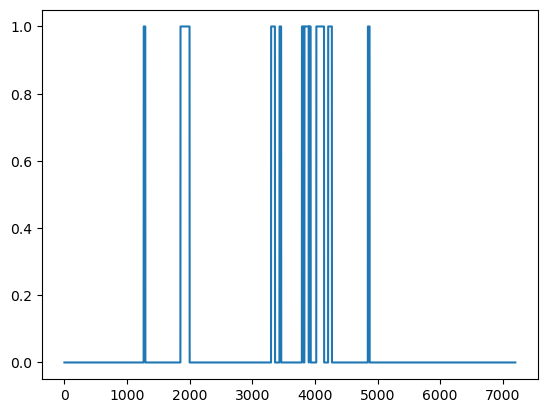

In [149]:
starttime = datetime.datetime(2023,10,2,0,0,0)
endtime = datetime.datetime(2023,10,7,0,0,0)

today = activityInPeriod(sittings, starttime, endtime)

plt.plot(today)

In [62]:
print(theseSittings.iloc[0].StartTime)
max(theseSittings.iloc[0].StartTime,starttime)

2023-10-04 07:00:27


Timestamp('2023-10-04 07:00:27')

In [ ]:
start = datetime.datetime(2023,10,14)
end = datetime.datetime(2023,10,14)

print(startdate)
print(startdate.weekday())
print(startdate.date())
begin = datetime.datetime(year=start.year, month=start.month, day=start.day)

firstmonday = begin - datetime.timedelta(days=start.weekday())
print(firstmonday)

stop = datetime.datetime(year=end.year, month=end.month, day=end.day)
lastsunday = stop + datetime.timedelta(days=7-stop.weekday())

print(lastsunday)


In [134]:
def weeklyRoutineOverTime(sits,start,end):
    '''We cover the interval with weekly periods and add up the sittings over these.
    Weeks start Monday 00:00 and end Sunday 23:59'''
    theseSittings = sits[sits.StartTime.between(start, end) | sits.EndTime.between(start , end)]

    #get monday immeditately prior to start
    begin = datetime.datetime(year=start.year, month=start.month, day=start.day)
    monday = begin - datetime.timedelta(days=start.weekday())
    stop = datetime.datetime(year=end.year, month=end.month, day=end.day)
    lastsunday = stop + datetime.timedelta(days=7-stop.weekday())
    
    allweeks = np.zeros(7*24*60, dtype=int)
    while monday < lastsunday:
        sunday = monday + datetime.timedelta(days=7)
        thisweek = activityInPeriod(sittings, monday, sunday)
        allweeks = allweeks + thisweek
        monday = monday + datetime.timedelta(days=7)

    return allweeks


In [146]:
start = datetime.datetime(2020,1,1,0,0,0)
end = datetime.datetime(2023,12,31,0,0,0)

allweeks = weeklyRoutineOverTime(sittings,start,end)

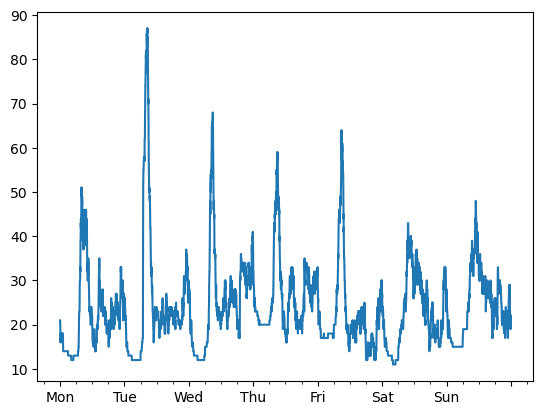

In [147]:
from matplotlib.ticker import FixedLocator, FixedFormatter, AutoMinorLocator

fig, ax = plt.subplots()
ax.plot(allweeks)
locs = [0, 1440, 1440*2, 1440*3, 1440*4, 1440*5, 1440*6, 1440*7]
labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax.xaxis.set_major_locator(FixedLocator(locs))
ax.xaxis.set_major_formatter(FixedFormatter(labels))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
plt.show()